# About Data
Data terdiri dari informasi bangunan di wilayah yang terkena gempa yang digunakan untuk babak penyisihan JOINTS UGM 2023

Dataset terdiri dari beberapa kolom diantaranya :
1. floors_before_eq (total) : jumlah total lantai pada bangunan sebelum gempa terjadi
2. old_building : usia bangunan (tahun)
3. plinth_area (ft^2) : luas bangunan (ft^2)
4. height_before_eq (ft) : tinggi bangunan sebelum terjadi gempa (kaki)
5. land_surface_condition : kondisi permukaan tanah disaat bangunan akan dibangun
6. type_of_foundation : jenis fondasi yang dipakai untuk bangunan tsb
7. type_of_roof : jenis atap yang dipakai untuk bangunan tsb
8. type_of_ground_floor : jenis lantai yang dipakai untuk ground-floor
9. type_of_other_floor : jenis lantai yang dipakai untuk selain ground-floor
10. position : Posisi bangunan tersebut apakah bersisian secara langsung dengan bangunan lain
11. building_plan_configuration : konfigurasi bangunan yang berkaitan dengan bentuk, ukuran, dan penempatan struktur utama bangunan
12. technical_solution_proposed : Solusi yang ditawarkan untuk bangunan yang terdampak gempa
13. legal_ownership_status : Status kepemilikan bangunan
14. has_secondary_use : Keterangan apakah bangunan memiliki kegunaan sekunder
15. type_of_reinforcement_concrete : Tipe beton bertulang/reinforcement concrete
16. residential_type : Tipe penggunaaan sebagai hunian
17. no_family_residing : Jumlah keluarga yang tinggal dalam bangunan tersebut
18. public_place_type : Tipe penggunaan sebagai tempat umum
19. industrial_use_type : Tipe industri
20. govermental_use_type : Tipe penggunaan sebagai bangunan pemerintahan
21. flexible_superstructure : Keterangan penggunaan superstructure yang fleksibel
22. wall_binding : Material yang digunakan sebagai perekat bahan pembentuk dinding
23. wall_material : Material dasar sebagai pembangun dinding
24. damage_grade (variabel target) : Tingkat kerusakan yang disebabkan oleh gempa (1-5)

Hal ini ditambah dengan beberapa penjelasan fitur :

type_of_reinforcement_concrete
- 0 : Unknown/not stated
- 1 : Clay
- 2 : Mortar + Cement
- 3 : Mortar + Cement, Clay
- 5 : Mud + Mortar, Clay
- 7 : Mud + Mortar, Clay, Cement + Mortar

wall_material
- 0 : Unknown/not stated
- 1 : Red Bricks
- 2 : Stone Bricks
- 3 : Red Bricks, Stone Bricks

type_of_reinforcement_concrete
- 0 : No reinforcement concrete
- 1 : Has non-engineered reinforcement concrete
- 2 : Has engineered reinforcement concrete
- 3 : Has both

# Tujuan
Menganalisis karakteristik bangunan yang memiliki tingkat kerusakan yang rendah

# Import

In [1269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler

# models
import optuna
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# metric used for the competition
from sklearn.metrics import f1_score

# Analisis Sekilas Data

In [1270]:
path = "..\\Datasets\\train.csv.zip"
df = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")
df = df.sort_index()
df = df.reset_index(drop=True)

test_path = "..\\Datasets\\test.csv.zip"
test = pd.read_csv(test_path,compression="zip", index_col='id')
test = test.sort_index()
test = test.reset_index(drop=True)

df.head()

d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
4,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0


### Terlihat beberapa missing value pada data, berikut adalah jumlah untuk setiap fitur

In [1271]:
df.isna().sum()

floors_before_eq (total)          332806
old_building                      239204
plinth_area (ft^2)                421208
height_before_eq (ft)             332806
land_surface_condition            301606
type_of_foundation                239204
type_of_roof                      421208
type_of_ground_floor              332806
type_of_other_floor               301606
position                          312006
building_plan_configuration       301606
technical_solution_proposed       676014
legal_ownership_status            124802
has_secondary_use                 197604
type_of_reinforcement_concrete    291206
residential_type                  270404
no_family_residing                145602
public_place_type                      0
industrial_use_type               114402
govermental_use_type              249604
flexible_superstructure            62400
wall_binding                       62400
wall_material                     228804
damage_grade                           0
dtype: int64

Berikut adalah jumlah duplicated values

In [1272]:
print(len(df)-len(df.drop_duplicates().dropna()))

676016


Berikut adalah jumlah data apabila seluruh nilai duplikat dan missing value dihilangkan

In [1273]:
len(df.dropna().drop_duplicates())

46799

In [1274]:
(len(df.dropna().drop_duplicates())/len(df)) * 100

6.474547429148537

Maka jumlah data yang tersisa hanya 6% dari data asli, jika missing value dihilangkan secara langsung, maka akan banyak informasi yang hilang, sehingga mari kita analisis lebih lanjut untuk menentukan apakah data perlu dilakukan drop missing value

### Preprocessing

In [1275]:
# impute NaN

df_dropped_na = df.copy()
train_data, val_data = train_test_split(df_dropped_na, test_size=0.2, random_state=33)

discrete = ['wall_binding', 'type_of_reinforcement_concrete', 'wall_material']
TARGET = 'damage_grade'

# splitted train data
train_data[discrete] = train_data[discrete].applymap(lambda x: str(x) if not pd.isna(x) else x)
val_data[discrete] = val_data[discrete].applymap(lambda x: str(x) if not pd.isna(x) else x)

# test data
test[discrete] = test[discrete].applymap(lambda x: str(float(x)))

train_data['public_place_type'] = train_data['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)
val_data['public_place_type'] = val_data['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)

train_data['technical_solution_proposed'] = train_data['technical_solution_proposed'].fillna(train_data.groupby(['public_place_type', 'damage_grade'])['technical_solution_proposed'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
val_data['technical_solution_proposed'] = val_data['technical_solution_proposed'].fillna(val_data.groupby(['public_place_type', 'damage_grade'])['technical_solution_proposed'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

train_data['wall_binding'] = train_data['wall_binding'].fillna(train_data.groupby(['public_place_type', 'damage_grade'])['wall_binding'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
val_data['wall_binding'] = val_data['wall_binding'].fillna(val_data.groupby(['public_place_type', 'damage_grade'])['wall_binding'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

train_data['type_of_reinforcement_concrete'] = train_data['type_of_reinforcement_concrete'].fillna(train_data.groupby(['public_place_type', 'damage_grade'])['type_of_reinforcement_concrete'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
val_data['type_of_reinforcement_concrete'] = val_data['type_of_reinforcement_concrete'].fillna(val_data.groupby(['public_place_type', 'damage_grade'])['type_of_reinforcement_concrete'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

train_data['wall_material'] = train_data['wall_material'].fillna(train_data.groupby(['public_place_type', 'damage_grade'])['wall_material'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
val_data['wall_material'] = val_data['wall_material'].fillna(val_data.groupby(['public_place_type', 'damage_grade'])['wall_material'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with mode for categorical columns
categorical_cols = df_dropped_na.select_dtypes(include='object').columns  # Get the column names of categorical columns
train_data[categorical_cols] = train_data[categorical_cols].fillna(train_data.groupby(['public_place_type', 'damage_grade'])[categorical_cols].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))
val_data[categorical_cols] = val_data[categorical_cols].fillna(val_data.groupby(['public_place_type', 'damage_grade'])[categorical_cols].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

# Impute missing values with median for numerical columns
numerical_cols_train = train_data.select_dtypes(include='number').columns  # Get the column names of numerical columns
numerical_cols_val = val_data.select_dtypes(include='number').columns  # Get the column names of numerical columns

# Define a custom function to fill missing values with median, handling empty median case
def fillna_with_median(x):
    median = x.mean()
    if pd.isna(median):
        return None  # or any other appropriate value
    else:
        return median

# Fill missing values with median based on 'public_place_type' and 'damage_grade'
train_data[numerical_cols_train] = train_data[numerical_cols_train].fillna(train_data.groupby(['public_place_type', 'damage_grade'])[numerical_cols_train].transform(fillna_with_median))
val_data[numerical_cols_val] = val_data[numerical_cols_val].fillna(val_data.groupby(['public_place_type', 'damage_grade'])[numerical_cols_val].transform(fillna_with_median))

d:\Anaconda\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/1721734599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['public_place_type'] = train_data['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/1721734599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [1276]:
train_data.isna().sum()

floors_before_eq (total)          0
old_building                      0
plinth_area (ft^2)                0
height_before_eq (ft)             0
land_surface_condition            0
type_of_foundation                0
type_of_roof                      0
type_of_ground_floor              0
type_of_other_floor               0
position                          0
building_plan_configuration       0
technical_solution_proposed       0
legal_ownership_status            0
has_secondary_use                 0
type_of_reinforcement_concrete    0
residential_type                  0
no_family_residing                0
public_place_type                 0
industrial_use_type               0
govermental_use_type              0
flexible_superstructure           0
wall_binding                      0
wall_material                     0
damage_grade                      0
dtype: int64

In [1277]:
test['public_place_type'] = test['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)

Selanjutnya adalah melakukan pembersihan data untuk dilakukan analisis lebih lanjut, pembersihan data pertama tama akan dilakukan pada kolom kategorikal

Beberapa fitur memiliki nilai problematik dengan delimiter dan case yang berbeda beda :
1. floors_before_eq (total)
2. type_of_foundation
3. type_of_roof
4. type_of_ground_floor
5. type_of_other_floor
6. legal_ownership_status

Pertama yang akan dibersihkan adalah fitur floors_before_eq, nilai teks akan diubah menjadi angka

In [1278]:
def transform_floors_before_eq(value):
    if isinstance(value, str):
        value = value.lower()
        if any(x in value for x in ['one','first','1']) :
            return 1
        elif any(x in value for x in ['two','second','2']) :
            return 2
        elif any(x in value for x in ['three','third','3','3.00']) :
            return 3
        elif any (x in value for x in ['four','fourth','4']) :
            return 4
        elif any (x in value for x in ['five','fifth','5']) :
            return 5
        else :
            return value
    else :
        return value


train_data['floors_before_eq (total)'] = train_data['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))
val_data['floors_before_eq (total)'] = val_data['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

test['floors_before_eq (total)'] = test['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/779056841.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['floors_before_eq (total)'] = train_data['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/779056841.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['floors_before_eq (total)'] = val_data['floors_before_eq (total)'].apply(lambda x : transform_floors_before_eq(x))


Kemudian, kita melakukan pembersihan pada type_x

In [1279]:
train_data['type_of_foundation'] = train_data['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

val_data['type_of_foundation'] = val_data['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

test['type_of_foundation'] = test['type_of_foundation'].replace({
    'Cement-Stone or Cement-Brick' : 'Cement-Stone/Brick',
    'Bamboo or Timber' : 'Bamboo/Timber',
    'RC' : 'Reinforced Concrete',
    'Bamboo/TImber' : 'Bamboo/Timber',
    'Others' : 'Other'
    })

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3890038526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['type_of_foundation'] = train_data['type_of_foundation'].replace({
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3890038526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['type_of_foundation'] = val_data['type_of_foundation'].replace({


In [1280]:
train_data['type_of_roof'] = train_data['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})
val_data['type_of_roof'] = val_data['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

test['type_of_roof'] = test['type_of_roof'].replace({
    'Bamboo or Timber-Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Light roof' : 'Bamboo/Timber Light roof',
    'Bamboo or Timber Heavy roof' : 'Bamboo/Timber Heavy roof',
    'Wood Light Roof or Bamboo Light Roof' : 'Wood Light roof/Bamboo Light roof',
    'Wood Light Roof or Bamboo Heavy Roof' : 'Wood Light roof/Bamboo Heavy roof',
    'Bamboo/TImber-Light Roof' : 'Bamboo/Timber Light roof',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc',
    'Reinforced Brick Slab/rcc/rbc' : 'rbs/rcc/rbc',
    'Bamboo/TImber-Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Bamboo or Timber Heavy Roof' : 'Bamboo/Timber Heavy roof',
    'Reinforced brick concrete/rcc/rbc' : 'rb/rbc'
})

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3158234642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['type_of_roof'] = train_data['type_of_roof'].replace({
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3158234642.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['type_of_roof'] = val_data['type_of_roof'].replace({


In [1281]:
train_data['type_of_ground_floor'] = train_data['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber',
    'soil, water, loam Mixed' : 'soil, water, loan Mixed'
})
val_data['type_of_ground_floor'] = val_data['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber',
    'soil, water, loam Mixed' : 'soil, water, loan Mixed'
})

test['type_of_ground_floor'] = test['type_of_ground_floor'].replace({
    'mud' : 'Mud',
    'Brick or Stone' : 'Brick/Stone',
    'reinforced concrete' : 'Reinforced Concrete',
    'RC' : 'Reinforced Concrete',
    'brick/stone' : 'Brick/Stone',
    'TImber' : 'Timber',
    'soil, water, loam Mixed' : 'soil, water, loan Mixed'
})

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3462319505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['type_of_ground_floor'] = train_data['type_of_ground_floor'].replace({
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3462319505.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['type_of_ground_floor'] = val_data['type_of_ground_floor'].replace({


In [1282]:
train_data['type_of_other_floor'] = train_data['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})
val_data['type_of_other_floor'] = val_data['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

test['type_of_other_floor'] = test['type_of_other_floor'].replace({
    'Timber-Planck' : 'Timber-Plank',
    'TImber/Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Timber Mud or Bamboo-Mud' : 'Timber/Bamboo-Mud',
    'Wood or Bamboo Mud' : 'Wood/Bamboo-Mud',
    'Wood-Mud or Bamboo Mud' : 'Wood/Bamboo Mud',
    'Reinforced brick concrete/rcc/rbc' : 'rcc/rbc',
    'reinforced cement concrete/rb/rbc' : 'rcc/rb/rbc'
})

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3293737606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['type_of_other_floor'] = train_data['type_of_other_floor'].replace({
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3293737606.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['type_of_other_floor'] = val_data['type_of_other_floor'].replace({


Kemudian, dilakukan pembersihan pada legal_ownership_status dan plinth_area

In [1283]:
train_data['type_of_other_floor'].unique()

array(['Timber/Bamboo-Mud', 'Timber-Plank', 'Wood/Bamboo Mud',
       'Not applicable', 'Lumber-plank', 'rcc/rb/rbc', 'Wood/Bamboo-Mud',
       'Wood-Plank', 'rcc/rbc'], dtype=object)

In [1284]:
def transform_use(x) :
    if x == 'Private Use' or x == 'Private' or x == 'Prvt' or x == 'Privste' :
        return 'private'
    elif x == 'Public' or x =='Public Space' or x == 'Public Use' :
        return 'public'
    elif x == 'Unknown':
        return 'Unknown'
    elif x == 'Unspecified':
        return 'Unspecified'
    elif x == 'Other' :
        return 'other'
    elif x == 'Institutional Use' or x == 'Institutionals' or x == 'Institutional' :
        return 'institutional'

train_data['legal_ownership_status'] = train_data['legal_ownership_status'].apply(lambda x : transform_use(x))
val_data['legal_ownership_status'] = val_data['legal_ownership_status'].apply(lambda x : transform_use(x))

test['legal_ownership_status'] = test['legal_ownership_status'].apply(lambda x : transform_use(x))

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3541977731.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['legal_ownership_status'] = train_data['legal_ownership_status'].apply(lambda x : transform_use(x))
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3541977731.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['legal_ownership_status'] = val_data['legal_ownership_status'].apply(lambda x : transform_use(x))


In [1285]:
def capAge(x) :
    if x > 200 :
        return 210
    else :
        return x
train_data['old_building'] = train_data['old_building'].apply(lambda x : capAge(x))
val_data['old_building'] = val_data['old_building'].apply(lambda x : capAge(x))

test['old_building'] = test['old_building'].apply(lambda x : capAge(x))

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3717240860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['old_building'] = train_data['old_building'].apply(lambda x : capAge(x))
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/3717240860.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['old_building'] = val_data['old_building'].apply(lambda x : capAge(x))


In [1286]:
train_data['plinth_area (ft^2)'] = train_data['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
train_data['plinth_area (ft^2)'] = pd.to_numeric(train_data['plinth_area (ft^2)'])

val_data['plinth_area (ft^2)'] = val_data['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
val_data['plinth_area (ft^2)'] = pd.to_numeric(val_data['plinth_area (ft^2)'])

test['plinth_area (ft^2)'] = test['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
test['plinth_area (ft^2)'] = pd.to_numeric(test['plinth_area (ft^2)'])

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/2121351135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['plinth_area (ft^2)'] = train_data['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/2121351135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['plinth_area (ft^2)'] = pd.to_numeric(train_data['plinth_area (ft^2)'])
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14

In [1287]:
train_data['height_before_eq (ft)'] = pd.to_numeric(train_data['height_before_eq (ft)'], errors='coerce')
train_data['floors_before_eq (total)'] = pd.to_numeric(train_data['floors_before_eq (total)'], errors='coerce')

val_data['height_before_eq (ft)'] = pd.to_numeric(val_data['height_before_eq (ft)'], errors='coerce')
val_data['floors_before_eq (total)'] = pd.to_numeric(val_data['floors_before_eq (total)'], errors='coerce')

test['height_before_eq (ft)'] = pd.to_numeric(test['height_before_eq (ft)'], errors='coerce')
test['floors_before_eq (total)'] = pd.to_numeric(test['floors_before_eq (total)'], errors='coerce')


C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/456651753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['height_before_eq (ft)'] = pd.to_numeric(train_data['height_before_eq (ft)'], errors='coerce')
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/456651753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['floors_before_eq (total)'] = pd.to_numeric(train_data['floors_before_eq (total)'], errors='coerce')
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/456651753.py:4: S

In [1288]:
# train_data['volume'] = train_data['plinth_area (ft^2)'] * train_data['height_before_eq (ft)']
# train_data['heightPerFloor'] = train_data['height_before_eq (ft)'] / train_data['floors_before_eq (total)']

# val_data['volume'] = val_data['plinth_area (ft^2)'] * val_data['height_before_eq (ft)']
# val_data['heightPerFloor'] = val_data['height_before_eq (ft)'] / val_data['floors_before_eq (total)']

# test['volume'] = test['plinth_area (ft^2)'] * test['height_before_eq (ft)']
# test['heightPerFloor'] = test['height_before_eq (ft)'] / test['floors_before_eq (total)']

In [1289]:
train_data['no_family_residing'] = train_data['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)
val_data['no_family_residing'] = val_data['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

test['no_family_residing'] = test['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)

C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/1516464638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['no_family_residing'] = train_data['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)
C:\Users\Rangga\AppData\Local\Temp/ipykernel_14500/1516464638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['no_family_residing'] = val_data['no_family_residing'].apply(lambda x: int(float(x)) if x != 'None' else 0)


In [1290]:
# train_data['type_of_foundation'] = train_data['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)
# val_data['type_of_foundation'] = val_data['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)
# test['type_of_foundation'] = test['type_of_foundation'].apply(lambda x: 'mortar-Stone/Brick' if 'mortar-Stone/Brick' in x else x)

### Log Transform

In [1291]:
# # train_data['volume'] = np.sqrt(train_data['volume'])
# # train_data['heightPerFloor'] = np.sqrt(train_data['heightPerFloor'])
# train_data = train_data.drop('floors_before_eq (total)', axis=1)
# train_data = train_data.drop('type_of_other_floor', axis=1)

# # val_data['volume'] = np.sqrt(val_data['volume'])
# # val_data['heightPerFloor'] = np.sqrt(val_data['heightPerFloor'])
# val_data = val_data.drop('floors_before_eq (total)', axis=1)
# val_data = val_data.drop('type_of_other_floor', axis=1)

# # test['volume'] = np.sqrt(test['volume'])
# # test['heightPerFloor'] = np.sqrt(test['heightPerFloor'])
# test = test.drop('floors_before_eq (total)', axis=1)
# test = test.drop('type_of_other_floor', axis=1)

In [1292]:
train_data.isna().sum()

floors_before_eq (total)          0
old_building                      0
plinth_area (ft^2)                0
height_before_eq (ft)             0
land_surface_condition            0
type_of_foundation                0
type_of_roof                      0
type_of_ground_floor              0
type_of_other_floor               0
position                          0
building_plan_configuration       0
technical_solution_proposed       0
legal_ownership_status            0
has_secondary_use                 0
type_of_reinforcement_concrete    0
residential_type                  0
no_family_residing                0
public_place_type                 0
industrial_use_type               0
govermental_use_type              0
flexible_superstructure           0
wall_binding                      0
wall_material                     0
damage_grade                      0
dtype: int64

In [1293]:
# df_dropped_na[['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material']].to_csv('building_materials.csv')

In [1294]:
# materials_pisah = pd.read_csv('materials_pisah.csv', index_col='Unnamed: 0')

# df_dropped_na = df_dropped_na.drop(['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material'], axis=1)

# df_dropped_na = pd.concat([materials_pisah, df_dropped_na], axis=1)

In [1295]:
train_data.shape

(578252, 24)

In [1296]:
train_data[train_data['old_building'] == 0] 

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
49167,1,0.0,140,8.000000,Flat,Bamboo/Timber,Bamboo/Timber Light roof,Clay,Not applicable,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
650578,2,0.0,300,16.066395,Flat,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber-Plank,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,3.0
388000,2,0.0,325,17.000000,Flat,Bamboo/Timber,Wood Light roof/Bamboo Heavy roof,Mud,Timber-Plank,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,available,0.0,0.0,1.0
35683,2,0.0,300,12.000000,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Timber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,3.0
108024,1,0.0,240,14.000000,Moderate slope,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Reinforced Concrete,Not applicable,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658671,1,0.0,250,9.000000,Flat,Reinforced Concrete,rbs/rcc/rbc,Reinforced Concrete,Not applicable,Not attached,...,2.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
626647,1,0.0,1000,10.000000,Flat,Bamboo/Timber,Bamboo/Timber Light roof,Mud,Not applicable,Attached-1 side,...,0.0,Hotel/Motel,0,Non-public,Non-industrial,Non-govermental,available,0.0,0.0,1.0
556040,2,0.0,300,12.000000,Flat,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Mud,Timber/Bamboo-Mud,Not attached,...,0.0,Non-residential,0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
12481,1,0.0,420,6.000000,Flat,Bamboo/Timber,Wood Light roof/Bamboo Light roof,Clay,Not applicable,Not attached,...,0.0,Non-residential,1,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


## Scalling, Hyperparam, & Model

In [1297]:
scaler3 = RobustScaler()
scaler4 = StandardScaler()

no_std = ['no_family_residing', 'floors_before_eq (total)', 'has_secondary_use']

# build_age_train = train_data['old_building']
# build_age_val = val_data['old_building']

train_num = train_data.select_dtypes(include='number').drop(TARGET, axis=1)
train_num = train_num.select_dtypes(include='number').drop(no_std, axis=1)
# build_age_train = pd.DataFrame(scaler3.fit_transform(build_age_train.to_numpy().reshape(-1,1)), columns = ['old_building'])
train_num = pd.DataFrame(scaler4.fit_transform(train_num), columns = train_num.columns)
# train_num['old_building'] = scaler3.fit_transform(train_num['old_building'].to_numpy().reshape(-1,1))
# train_num['plinth_area (ft^2)'] = scaler3.fit_transform(train_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
# train_num['volume'] = scaler3.fit_transform(train_num['volume'].to_numpy().reshape(-1,1))
# train_num['heightPerFloor'] = scaler3.fit_transform(train_num['heightPerFloor'].to_numpy().reshape(-1,1))
# train_num['height_before_eq (ft)'] = scaler3.fit_transform(train_num['height_before_eq (ft)'].to_numpy().reshape(-1,1))
# train_num['floors_before_eq (total)'] = scaler3.fit_transform(train_num['floors_before_eq (total)'].to_numpy().reshape(-1,1))

val_num = val_data.select_dtypes(include='number').drop(TARGET, axis=1)
val_num = val_num.select_dtypes(include='number').drop(no_std, axis=1)
# build_age_val = pd.DataFrame(scaler3.transform(build_age_val.to_numpy().reshape(-1,1)), columns = ['old_building'])
val_num = pd.DataFrame(scaler4.transform(val_num), columns = val_num.columns)
# val_num['old_building'] = scaler3.fit_transform(val_num['old_building'].to_numpy().reshape(-1,1))
# val_num['plinth_area (ft^2)'] = scaler3.fit_transform(val_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
# val_num['volume'] = scaler3.fit_transform(val_num['volume'].to_numpy().reshape(-1,1))
# val_num['heightPerFloor'] = scaler3.fit_transform(val_num['heightPerFloor'].to_numpy().reshape(-1,1))
# val_num['height_before_eq (ft)'] = scaler3.fit_transform(val_num['height_before_eq (ft)'].to_numpy().reshape(-1,1))
# val_num['floors_before_eq (total)'] = scaler3.fit_transform(val_num['floors_before_eq (total)'].to_numpy().reshape(-1,1))

train_cat = train_data.select_dtypes('object')
val_cat = val_data.select_dtypes('object')

encoder = OneHotEncoder(drop='first')

train_concat = pd.concat([train_data[no_std].reset_index(drop=True), train_num.reset_index(drop=True), pd.DataFrame(encoder.fit_transform(train_cat).toarray(), columns=encoder.get_feature_names(train_cat.columns)).reset_index(drop=True), train_data[TARGET].reset_index(drop=True)], axis=1)
val_concat = pd.concat([val_data[no_std].reset_index(drop=True), val_num.reset_index(drop=True), pd.DataFrame(encoder.transform(val_cat).toarray(), columns=encoder.get_feature_names(val_cat.columns)).reset_index(drop=True), val_data[TARGET].reset_index(drop=True)], axis=1)

In [1298]:
train_data.describe()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),has_secondary_use,no_family_residing,damage_grade
count,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000
mean,2.047498,22.189267,430.417041,16.044281,0.121059,0.985183,3.644743
std,0.483901,17.452587,252.238839,4.068275,0.279186,0.402467,1.341718
min,1.000000,0.000000,70.000000,6.000000,0.000000,0.000000,1.000000
25%,2.000000,12.000000,300.000000,15.000000,0.000000,1.000000,3.000000
50%,2.000000,22.000000,300.000000,16.204956,0.000000,1.000000,4.000000
75%,2.000000,26.536270,450.000000,16.362747,0.118161,1.000000,5.000000
max,9.000000,210.000000,1000.000000,99.000000,1.000000,11.000000,5.000000


In [1299]:
# build_age_test = test['old_building']


test_num = test.select_dtypes(include='number') #.drop('old_building', axis=1)
test_num = test_num.select_dtypes(include='number').drop(no_std, axis=1)
# build_age_test = pd.DataFrame(scaler3.transform(build_age_test.to_numpy().reshape(-1,1)), columns = ['old_building'])
test_num = pd.DataFrame(scaler4.transform(test_num), columns = test_num.columns)
# test_num['old_building'] = scaler4.transform(test_num['old_building'].to_numpy().reshape(-1,1))
# test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
# test_num['plinth_area (ft^2)'] = scaler3.fit_transform(test_num['plinth_area (ft^2)'].to_numpy().reshape(-1,1))
# test_num['volume'] = scaler3.fit_transform(test_num['volume'].to_numpy().reshape(-1,1))
# test_num['heightPerFloor'] = scaler3.fit_transform(test_num['heightPerFloor'].to_numpy().reshape(-1,1))
# test_num['height_before_eq (ft)'] = scaler3.fit_transform(test_num['height_before_eq (ft)'].to_numpy().reshape(-1,1))
# test_num['floors_before_eq (total)'] = scaler3.fit_transform(test_num['floors_before_eq (total)'].to_numpy().reshape(-1,1))

test_cat = test.select_dtypes('object')
test_concat = pd.concat([test[no_std],test_num, pd.DataFrame(encoder.transform(test_cat).toarray(), columns=encoder.get_feature_names(test_cat.columns))], axis=1)
test_concat

,no_family_residing,floors_before_eq (total),has_secondary_use,old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition_Moderate slope,land_surface_condition_Steep slope,type_of_foundation_Cement-Stone/Brick,type_of_foundation_Clay Sand Mixed mortar-Stone/Brick,...,govermental_use_type_Police Offices,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1.0,wall_material_2.0,wall_material_3.0
0,1,2,0.0,-0.870317,-0.049227,-0.502494,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,3,0.0,-0.526528,-0.136446,1.218139,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,3,0.0,1.020522,-0.120588,0.480725,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,2,0.0,0.161050,-0.207807,0.972334,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,2,0.0,-0.984913,-0.219701,0.972334,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242077,1,2,0.0,-0.411932,-0.754908,-0.256689,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242078,1,3,0.0,-1.042211,-1.016565,0.480725,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242079,1,2,0.0,-0.469230,-0.219701,-0.502494,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242080,1,2,0.0,-0.755721,0.220359,-0.010885,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [1300]:
# X = concat.drop(TARGET, axis=1)
# y = concat[TARGET]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
X_train = train_concat.drop(TARGET, axis=1)
X_test = val_concat.drop(TARGET, axis=1)
y_train = train_concat[TARGET]
y_test = val_concat[TARGET]

In [1301]:
X_test.isna().sum().sum()

0

In [1302]:
# rus = RandomUnderSampler(random_state=33)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [1303]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 150)
#     max_depth = int(trial.suggest_loguniform('max_depth', 70, 100))
#     clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_macro').mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [1304]:
np.setdiff1d(X_train.columns, test_concat.columns)

array([], dtype=object)

In [1305]:
X_train.shape

(578252, 84)

In [1306]:
X_train.describe()

,no_family_residing,floors_before_eq (total),has_secondary_use,old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition_Moderate slope,land_surface_condition_Steep slope,type_of_foundation_Cement-Stone/Brick,type_of_foundation_Clay Sand Mixed mortar-Stone/Brick,...,govermental_use_type_Police Offices,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1.0,wall_material_2.0,wall_material_3.0
count,578252.000000,578252.000000,578252.000000,5.782520e+05,5.782520e+05,5.782520e+05,578252.000000,578252.000000,578252.000000,578252.000000,...,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000,578252.000000
mean,0.985183,2.047498,0.121059,6.661240e-16,5.656815e-15,-8.090709e-16,0.080416,0.019242,0.034300,0.607323,...,0.000119,0.926971,0.015189,0.065655,0.000380,0.813875,0.010120,0.053700,0.837080,0.009588
std,0.402467,0.483901,0.279186,1.000001e+00,1.000001e+00,1.000001e+00,0.271937,0.137376,0.181999,0.488346,...,0.010923,0.260184,0.122304,0.247678,0.019502,0.389208,0.100089,0.225424,0.369293,0.097445
min,0.000000,1.000000,0.000000,-1.271404e+00,-1.428873e+00,-2.468931e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,-5.838261e-01,-5.170384e-01,-2.566891e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,2.000000,0.000000,-1.084465e-02,-5.170384e-01,3.949451e-02,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,2.000000,0.118161,2.490752e-01,7.763664e-02,7.828044e-02,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,11.000000,9.000000,1.000000,1.076121e+01,2.258112e+00,2.039090e+01,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1307]:
model = RandomForestClassifier(n_estimators=128, max_depth=93)
model.fit(X_train, y_train)
result = model.predict(X_test)
score = f1_score(y_test, result, average='macro')
score

In [419]:
model = RandomForestClassifier(n_estimators=128, max_depth=93)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro')
for i, score in enumerate(scores) :
    print(f'Fold {i} : {score}')

KeyboardInterrupt: 

In [485]:
np.setdiff1d(X_train.columns, test_concat.columns)

array([], dtype=object)

In [1052]:
test_result = model.predict(test_concat)

final_result = pd.DataFrame(test_result)

final_result = final_result.rename(columns={0 : 'damage_grade'})
final_result.insert(0, 'id', final_result.index)
final_result = final_result.set_index('id')
final_result['damage_grade'] = final_result['damage_grade'].astype('int')

In [1053]:
final_result

,damage_grade
id,
0,4
1,4
2,4
3,5
4,2
...,...
242077,3
242078,5
242079,1


In [1054]:
final_result.value_counts()

damage_grade
5               103861
4                45334
3                41352
2                35033
1                16502
dtype: int64

In [548]:
final_result.to_csv('Percobaan_150423_RFC_handled_separate_undersampled.csv')

In [128]:
# final_result.to_csv('result_optuna_technical_diimput_renew_pake_fir.csv')

Setelah melakukan berbagai pembersihan, selanjutnya kita akan melakukan EDA

# EDA

Pertama, mari kita analisis bahan bahan yang digunakan untuk bangunan

In [129]:
df_building_materials = df_dropped_na.copy()
df_building_materials = df_dropped_na[[col for col in df_dropped_na.columns if col in ['type_of_foundation','type_of_roof','type_of_ground_floor','type_of_other_floor','type_of_reinforcement_concrete','wall_binding','wall_material','damage_grade']]]

In [130]:
df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['type_of_foundation'].value_counts()[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

([<matplotlib.axis.XTick at 0x1c2bd60fa30>],
 [Text(0, 0, 'Clay Sand Mixed \n mortar-Stone/Brick')])

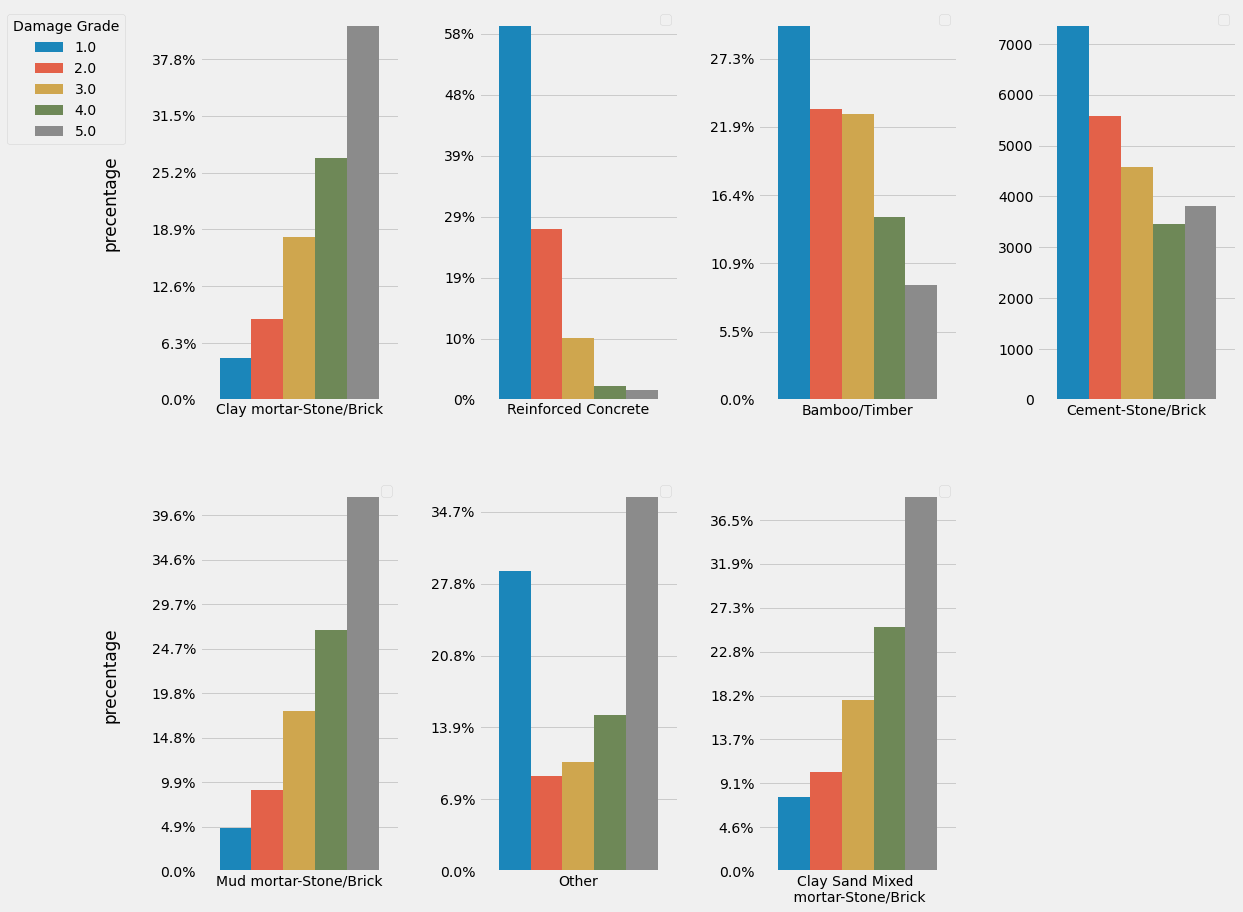

In [ ]:
import matplotlib.ticker as mtick

plt.figure(figsize=(18,15))
plt.style.use('fivethirtyeight')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,)

plt.subplot(2,4,1)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick']['damage_grade'])
plt.legend(loc='upper left', bbox_to_anchor=(-1,1), title='Damage Grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Clay mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('precentage')
ax.yaxis.set_label_coords(-0.4,0.5)

plt.subplot(2,4,2)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Reinforced Concrete'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,3)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Bamboo/Timber'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,4)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Cement-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Cement-Stone/Brick']['damage_grade'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')


plt.subplot(2,4,5)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Mud mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('precentage')
ax.yaxis.set_label_coords(-0.4,0.5)

plt.subplot(2,4,6)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Other']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Other']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Other'])))
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,4,7)
ax = sns.countplot(x=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick']['type_of_foundation'], hue=df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick']['damage_grade'])
plt.legend('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df_building_materials[df_building_materials['type_of_foundation'] == 'Clay Sand Mixed mortar-Stone/Brick'])))
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=[0],labels=['Clay Sand Mixed \n mortar-Stone/Brick'])


Dari visualisasi tersebut dapat disimpulkan bahwa material yang aman untuk dijadikan pondasi bangunan adalah Reinforced Concrete, Bamboo/Timber, dan Cement-Stone/Brick

In [ ]:
df_building_materials['type_of_ground_floor'].unique()

array(['Clay', 'Mud', 'Brick/Stone', 'Reinforced Concrete',
       'soil, water, loam Mixed', 'Other', 'Lumber', 'Timber', 'Wood'],
      dtype=object)